In [98]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, ttest_1samp, ttest_ind, mannwhitneyu
import statsmodels.stats.api as sms #mean calculation with confidence interval
from statsmodels.stats.proportion import proportions_ztest #for variables with binary values

#Setting view options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Dataset from kaggle
https://www.kaggle.com/datasets/adarsh0806/ab-testing-practice?resource=download

The dataset emulates information regarding visits made by users on an imaginary retail website around the United Kingdom. The users are found to be in two groups, A and B, each of which represents a control group and treatment group respectively. Imagine that the retail company needs to test out a new change on the website which is, "Do people spend time on a website if the website background color is White or Black". This question is asked to achieve the end goal of the analysis which is to improve user engagement, whether it is through a purchase, signing up, etc.

So, in this scenario, let the color 'White' be assigned to Group A which is the default setting for the background color on the website, representing the control group. Also, let the color 'Black' be equivalent to Group B which is the newer setting to be tested. And the main goal is to understand whether there is a significant improvement in website views if the newer setting is applied. This can be answered through the use of A/B Testing.

The column description is given as follows:

User ID: Serves as an identifier for each user.

Group: Contains both the control group (A) and treatment group (B).

Page Views: Number of pages the user viewed during their session.

Time Spent: The total amount of time, in seconds, that the user spent on the site during the session.

Conversion: Indicates whether a user has completed a desired action (Yes/No).

Device: Type of device used to access the website.

Location: The country in UK where the user is based in.

The dataset can also be used to derive segment-based insights through appropriate data visualization based on device type and location.

In [126]:
# Load data
data = pd.read_csv(r'ab_testing.csv')
data

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland
...,...,...,...,...,...,...,...
4995,16360,B,12,313,No,Mobile,Wales
4996,18084,B,10,313,No,Desktop,Northern Ireland
4997,12063,A,11,156,No,Desktop,England
4998,18647,B,13,346,No,Desktop,Wales


In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB


In [128]:
data.duplicated().sum()

0

## Exploratory Data Analysis

In [129]:
data['Conversion'].value_counts(normalize=True)

No    0.90300
Yes   0.09700
Name: Conversion, dtype: float64

Only the 1% of the entire population has a conversion 

In [130]:
data["Conversion"] = data["Conversion"].apply(lambda x: 1 if x == "Yes" else 0)
data.rename(columns=lambda col: col.replace(' ',''),inplace=True)

In [131]:
data['Device'].value_counts(normalize=True)

Desktop   0.50760
Mobile    0.49240
Name: Device, dtype: float64

the distribution between desktop and mobile access to the website has a relation almost of 50/50

In [132]:
data['Location'].value_counts(normalize=True)

Scotland           0.25620
England            0.24920
Northern Ireland   0.24840
Wales              0.24620
Name: Location, dtype: float64

the distribution along the UK is aprox 25% per city 

In [133]:
data.describe().drop('UserID',axis=1).round(3)

,PageViews,TimeSpent,Conversion
count,5000.00000,5000.00000,5000.00000
mean,7.53800,242.51300,0.09700
std,4.02200,118.25400,0.29600
min,1.00000,40.00000,0.00000
25%,4.00000,137.00000,0.00000
50%,8.00000,243.00000,0.00000
75%,11.00000,346.00000,0.00000
max,14.00000,449.00000,1.00000


### Who are the users with conversion?

Text(0.5, 1.0, 'Conversion rate per group')

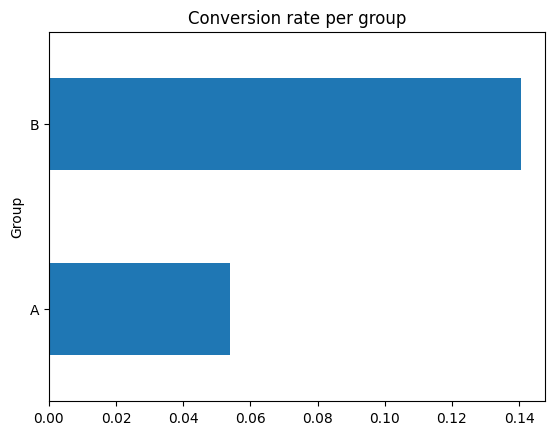

In [134]:
data.groupby('Group')['Conversion'].mean().plot(kind='barh')
plt.title('Conversion rate per group')

seems like the group B has better response to the website with almost 10% of basis points difference with respect to the group A

Text(0.5, 1.0, 'Conversion rate per group and device')

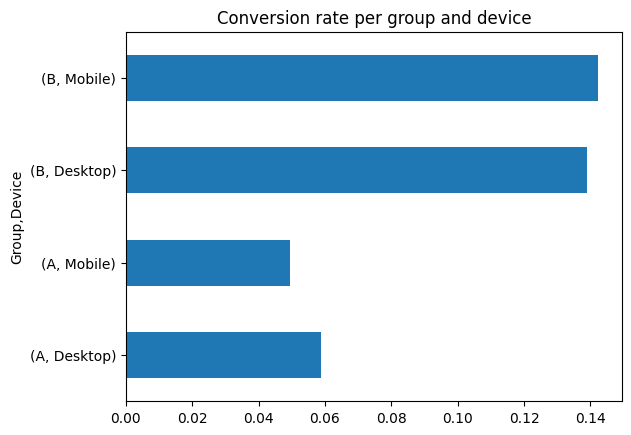

In [135]:
data.groupby(['Group','Device'])['Conversion'].mean().plot(kind='barh')
plt.title('Conversion rate per group and device')

Text(0.5, 1.0, 'Conversion rate per group, device and location')

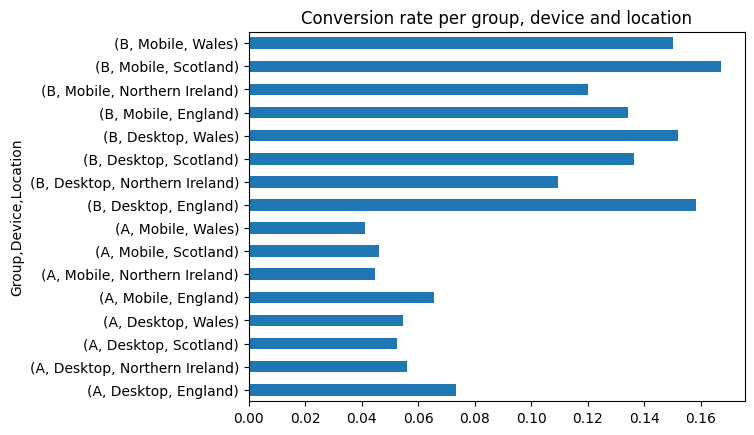

In [136]:
data.groupby(['Group','Device','Location'])['Conversion'].mean().plot(kind='barh')
plt.title('Conversion rate per group, device and location')

the conversion along the location and devices is greater for the group B with a range of conversion between 11% and 17% in the different combinations for device and location, meanwhile the group A is in a range of 4% and 8%.

## A/B test

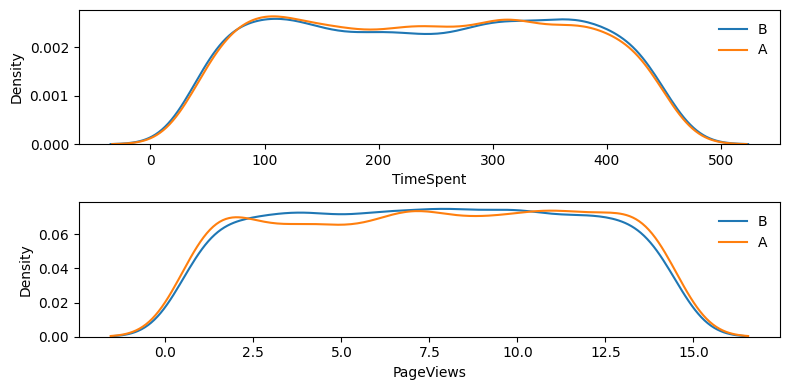

In [137]:
plt.figure(figsize=(8,4))
for j,var in enumerate(['TimeSpent','PageViews']):
    plt.subplot(2,1,j+1)
    for i in data['Group'].unique():
        sns.kdeplot(data=data[data['Group']==i],x=var,label=i)
    plt.legend(frameon=False)
plt.tight_layout()
plt.show()

the distribution for each group by the time spent and page views in the website are similar and looks like they follow a normal distribution, therefore the use of the Shapiro-Wilk test can give us the conclustion of there is a normal distribution, where:

$H_{0}$ = The data follows a normal distribution 

$H_{1}$ = The data does not follow a normal distribution

In [143]:
pvalue = shapiro(data.query("Group =='A'")["TimeSpent"])[1]
print(f"p-value for TimeSpent for group A = %.4f" % pvalue)

pvalue = shapiro(data.query("Group =='B'")["TimeSpent"])[1]
print(f"                      for group B = %.4f" % pvalue)

pvalue = shapiro(data.query("Group =='A'")["PageViews"])[1]
print(f"p-value for PageViews for group A = %.4f" % pvalue)

pvalue = shapiro(data.query("Group =='B'")["PageViews"])[1]
print(f"                      for group B = %.4f" % pvalue)

p-value for TimeSpent for group A = 0.0000
                      for group B = 0.0000
p-value for PageViews for group A = 0.0000
                      for group B = 0.0000


given the TimeSpent and PageViews does not follow a normal distribution the statistical significance between each group is going to be tested by the Mann-Whitney U test

In [146]:
pvalue = mannwhitneyu(data.loc[data["Group"] == "A", "TimeSpent"],
                      data.loc[data["Group"] == "B", "TimeSpent"])[1]
print("p-value for TimeSpent = %.4f" % pvalue)

pvalue = mannwhitneyu(data.loc[data["Group"] == "A", "PageViews"],
                      data.loc[data["Group"] == "B", "PageViews"])[1]
print("p-value for PageViews = %.4f" % pvalue)

p-value for TimeSpent = 0.6420
p-value for PageViews = 0.4247


given a p-value > 0.05 the null hypothesis can be rejected, so there is not statistical significance difference between the two variables for each group

### There is a difference between the two groups given by the conversion rate?

In [148]:
pvalue = mannwhitneyu(data.loc[data["Group"] == "A", "Conversion"],
                      data.loc[data["Group"] == "B", "Conversion"])[1]
print("p-value for Conversion = %.4f" % pvalue)

p-value for Conversion = 0.0000


since the p-value is less than the significance level the null hypothesis can be rejected, so statistiscally, there is a significative difference between the two groups